[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Yang_et_al_2018/fig_2.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examplesPySDM_examples/Yang_et_al_2018/fig_2.ipynb)    
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Yang_et_al_2018/fig_2.ipynb)

#### based on Fig. 2 from Yang et al. 2018 (Atmos. Chem. Phys. 18)  "_Cloud droplet size distribution broadening during diffusional growth: ripening amplified by deactivation and reactivation_"   
https://doi.org/10.5194/acp-18-7313-2018

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from open_atmos_jupyter_utils import show_plot
from PySDM_examples.Yang_et_al_2018 import Simulation, Settings

figsize = (9, 6)

In [3]:
import pint
si = pint.UnitRegistry()
si.setup_matplotlib()

In [4]:
ix51 = 40
ix503 = 99

In [5]:
def runner():
    settings = Settings(dt_output = 60*10*si.second)
    
    assert round(settings.r_dry[  ix51]*1e9, 0) == 51
    assert round(settings.r_dry[ ix503]*1e9, 0) == 503

    simulation = Simulation(settings)

    output = simulation.run()
    result = {}
    
    result['r_bins_values'] = np.array(output['r_bins_values']).T / (settings.mass_of_dry_air)
    result['r_bins_edges'] = settings.r_bins_edges
    
    result['r'] = np.array(output['r']).T * si.metres
    result['t'] = output["t"] * si.seconds
    result['z'] = output["z"] * si.metres
    result['S'] = np.array(output["S"]) * si.dimensionless
    result['liquid_water_mixing_ratio'] = (settings.initial_water_vapour_mixing_ratio - np.array(output["water_vapour_mixing_ratio"])) * si.kilogram / si.kilogram
    result['T'] = np.array(output["T"])
    result['n'] = settings.n / (settings.mass_of_dry_air * si.kilogram)
    result['dt_max'] = settings.dt_max
    result['rtol_thd'] = settings.rtol_thd
    result['rtol_x'] = settings.rtol_x
    result['dt_cond_max'] = output['dt_cond_max']
    result['dt_cond_min'] = output['dt_cond_min']
    
    result['ripening rate'] = output['ripening rate']
    for key in ('r_act','r_mean_gt_1_um'):
        result[key] = output[key]*si.m
    return result

In [6]:
outputs = []
outputs.append(runner())

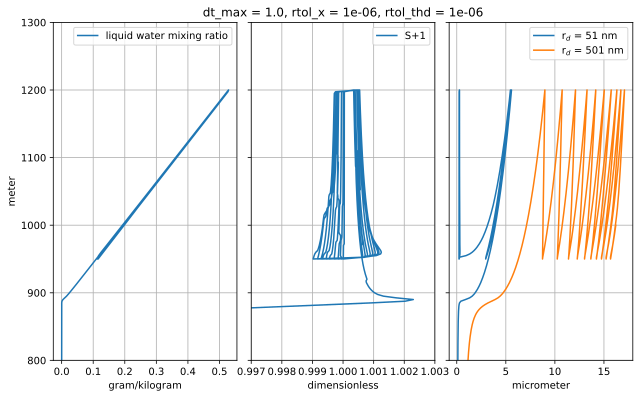

HTML(value="<a href='./q_S_rd.pdf' target='_blank'>./q_S_rd.pdf</a><br>")

In [7]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=figsize)
if len(outputs)==1:
    ax = np.array(ax).reshape(len(outputs),3)
for i, out in enumerate(outputs):
    dt_max = out['dt_max']
    rtol_x = out['rtol_x']
    rtol_thd = out['rtol_thd']
    tols = f'rtol_x = {rtol_x}, rtol_thd = {rtol_thd}'
        
    ax[i,1].set_title(f'dt_max = {dt_max}, '+tols)
    
    ax[i,0].set_ylim([800, 1300])
    ax[i,0].plot(out['liquid_water_mixing_ratio'], out['z'], label="liquid water mixing ratio")
    ax[i,0].xaxis.set_units(si.gram / si.kilogram)
    ax[i,0].grid()
    ax[i,0].legend(loc='best')

    ax[i,1].plot(out['S']+1, out['z'], label="S+1")
    ax[i,1].grid()
    ax[i,1].legend(loc='best')
    ax[i,1].set_xlim([0.997, 1.003])

    ax[i,2].plot(out['r'][ix51], out['z'], label="r$_d$ = 51 nm")
    ax[i,2].plot(out['r'][ix503], out['z'], label="r$_d$ = 501 nm")
    ax[i,2].grid()
    ax[i,2].xaxis.set_units(si.micrometre)
    ax[i,2].legend(loc='best')
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)

show_plot(filename='q_S_rd.pdf')

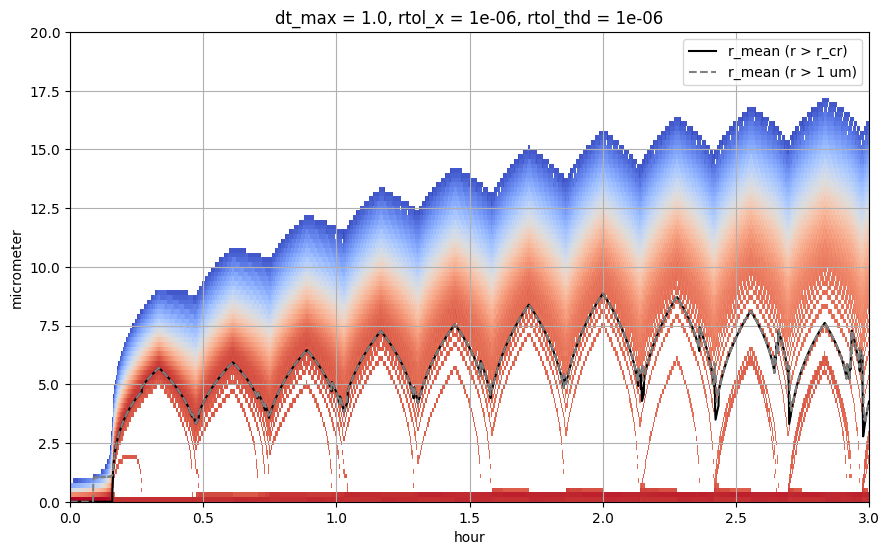

HTML(value="<a href='./spectrum.pdf' target='_blank'>./spectrum.pdf</a><br>")

In [8]:
mgn = lambda value, unit: (value / unit).to_base_units().magnitude

fig, ax = plt.subplots(1, 1, sharex=True, figsize=figsize)
if len(outputs)==1:
    ax = (ax,)
for i, out in enumerate(outputs):
    dt_max = out['dt_max']
    if i==2:
        rtol = out['rtol_bdf']
        tols = f'tolerance = {rtol}'
    else:
        rtol_x = out['rtol_x']
        rtol_thd = out['rtol_thd']
        tols = f'rtol_x = {rtol_x}, rtol_thd = {rtol_thd}'
    
    hist = out['r_bins_values']
    hist = (hist[:,0:-1] + hist[:,1:])/2
    xedges = out['t'].magnitude
    yedges = out['r_bins_edges']
    
    xunit = si.hour
    yunit = si.micrometres

    c = ax[i].pcolormesh(
        mgn(xedges * out['t'].units, xunit), 
        mgn(yedges * out['r'].units, yunit), 
        hist,
        cmap = 'coolwarm', shading='auto',
        norm = mpl.colors.LogNorm()
    )
    ax[i].set_title(f'dt_max = {dt_max}, '+tols)
    ax[i].yaxis.set_units(yunit)
    ax[i].xaxis.set_units(xunit)
    ax[i].set_ylim([0, 20])

    ax[i].plot(out['t'], out["r_act"], label="r_mean (r > r_cr)", color='black')
    ax[i].plot(out['t'], out["r_mean_gt_1_um"], label="r_mean (r > 1 um)", linestyle='--', color='gray')
    ax[i].legend(loc='best')
    ax[i].grid()
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
show_plot(filename='spectrum.pdf', inline_format='png')